In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import os

from matplotlib import pyplot as plt

from metavision_core.event_io import RawReader

import lib

In [2]:
plt.rcParams['figure.figsize'] = [8, 6]

#### Loading the dataset

In [3]:
import numpy as np

dataset_path = "dataset/45/"

filenames = np.array(lib.load_filenames_to_matrix(dataset_path))

raws = []
for fxs in filenames:
	rawsx = [RawReader(f) for f in fxs]
	raws.append(rawsx)

distances = [1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 4.0, 5.0]
frequencies = [10, 25, 50, 100, 250, 500, 1000, 2500, 5000, 10000, 20000, 30000]
bin_width_us = 1000

#### Get the events from raws

In [4]:
events = lib.recursive_map(lib.raw_load_events, raws, dtime=1000000, start_ts=0.1 * 1e6)

#### Process the data

In [5]:
#check if exists "avg_events.npy (precomputed) - takes a long time to compute"
avg_events_array = None

if os.path.exists("avg_events.npz"):
	k = ['avg_events_array_45', 'std_events_array_45', 'avg_events_array_0', 'std_events_array_0']
	npzfile = np.load("avg_events.npz")
	avg_events_array_45 = npzfile[k[0]]
	std_events_array_45 = npzfile[k[1]]
	avg_events_array_0 = npzfile[k[2]]
	std_events_array_0 = npzfile[k[3]]

else:
	avg_events_matrix = []
	std_events_matrix = []

	for distance_idx, event_list in enumerate(events):
		distance_avg_events = []
		distance_std_events = []
		print(f"Processing distance {distances[distance_idx]} meters")
		for freq_idx, event_set in enumerate(event_list):
			frequency = frequencies[freq_idx]
			
			if len(event_set) == 0:
				print(f"  No events for frequency {frequency} Hz")
				distance_avg_events.append(np.nan)  #NaN for missing data
				continue
			
			#if needs to be adjusted
			prominence_value = None
			
			#event data processing
			vals_dict = lib.process_event_data(
				event_set,
				frequency,
				prominence_value=prominence_value
			)

			avg_events, std_events, event_counts, signal, time_axis, peak_indices = vals_dict.values()
			
			print(f"  Frequency: {frequency} Hz, Average Events per Period: {avg_events}")
			
			distance_avg_events.append(avg_events)
			distance_std_events.append(std_events)
			
			# plt.figure(figsize=(12, 6))
			# plt.plot(time_axis, signal)
			# plt.plot(time_axis[peak_indices], signal[peak_indices], 'rx')  # Mark peaks
			# plt.xlabel('Time (us)')
			# plt.ylabel('Summed Polarity')
			# plt.title(f'Distance {distances[distance_idx]} m, Frequency {frequency} Hz')
			# plt.show()
		
		avg_events_matrix.append(distance_avg_events)
		std_events_matrix.append(distance_std_events)

	avg_events_array = np.array(avg_events_matrix)
	std_events_array = np.array(std_events_matrix)

In [ ]:
#save the events array to npz
#load the _0 from the npz file

#avg_events_array_0 = np.load("avg_events_0.npz")["avg_events_array_0"]
#std_events_array_0 = np.load("avg_events_0.npz")["std_events_array_0"]

#np.savez("avg_events.npz", avg_events_array_45=avg_events_array, std_events_array_45=std_events_array, avg_events_array_0=avg_events_array_0, std_events_array_0=std_events_array_0)

### Plot the effect of distance

In [6]:
evs = avg_events_array_0
stdevs = std_events_array_0

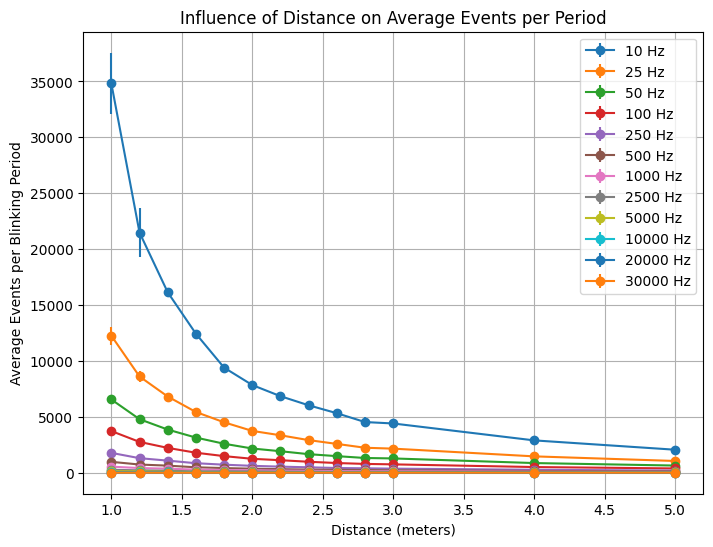

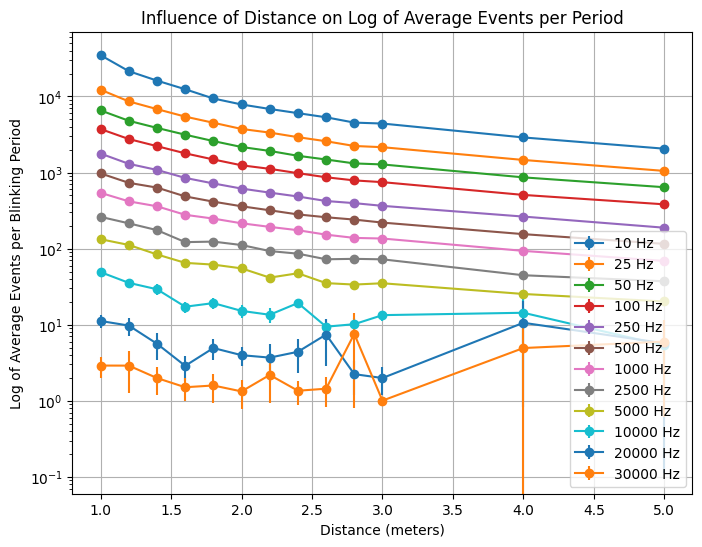

In [7]:
lib.plot_avg_events_vs_distance(distances, evs, stdevs, frequencies)
lib.plot_log_avg_events_vs_distance(distances, evs, stdevs, frequencies)

### Plot the effect of frequency

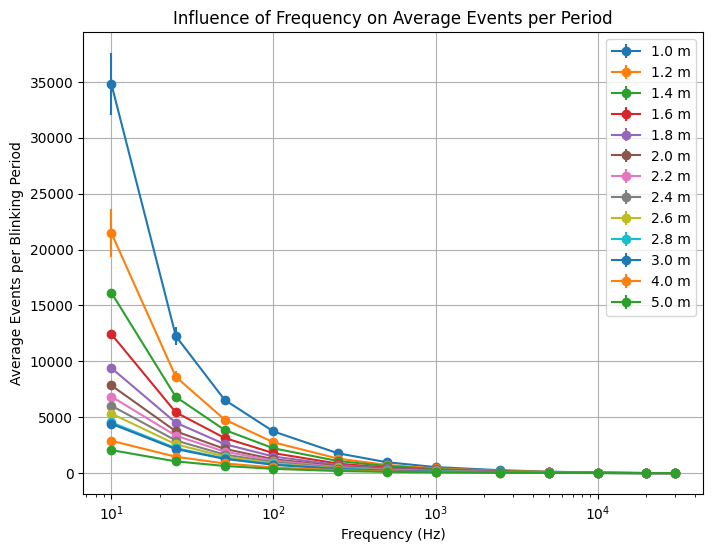

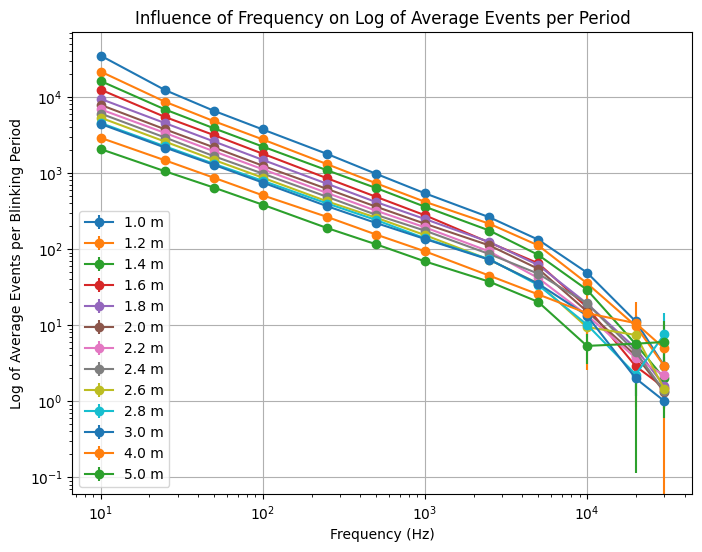

In [11]:
lib.plot_avg_events_vs_frequency(frequencies, evs, stdevs, distances)
lib.plot_log_avg_events_vs_frequency(frequencies, evs, stdevs, distances)

#### Fitting a polynomial curve to the data using *scipy.optimize.curve_fit*

In [12]:
avg_events_array = avg_events_array_45.copy()

Frequency index 0: Fitted exponent n: 2.31
Frequency index 1: Fitted exponent n: 1.83
Frequency index 2: Fitted exponent n: 1.62
Frequency index 3: Fitted exponent n: 1.51
Frequency index 4: Fitted exponent n: 1.43
Frequency index 5: Fitted exponent n: 1.35
Frequency index 6: Fitted exponent n: 1.27
Frequency index 7: Fitted exponent n: 1.17
Frequency index 8: Fitted exponent n: 1.05
Frequency index 9: Fitted exponent n: 1.04
Frequency index 10: Fitted exponent n: 0.90
Frequency index 11: Fitted exponent n: 0.37


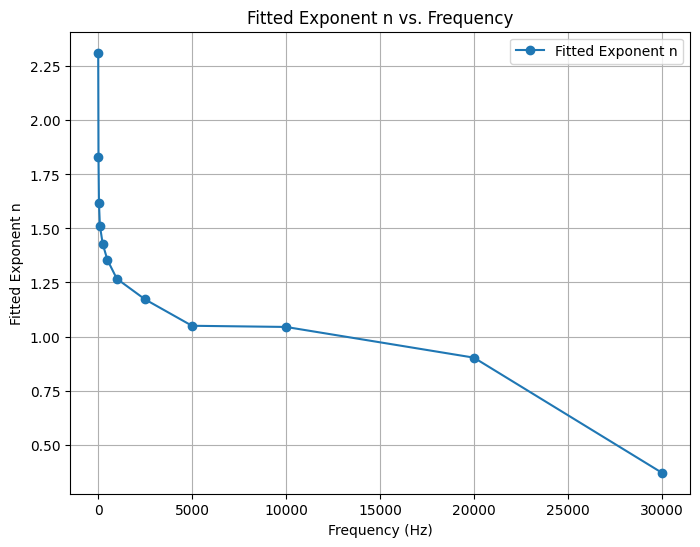

In [16]:
from scipy.optimize import curve_fit

def power_law(x, k, n):
	return k * x ** (-n)

distances_array = np.array(distances)

k_fits = []
n_fits = []

#plot optimal fit for each frequency
for freq_idx in range(avg_events_array.shape[1]):
	avg_events = avg_events_array[:, freq_idx]

	valid_indices = ~np.isnan(avg_events)
	distances_valid = distances_array[valid_indices]
	avg_events_valid = avg_events[valid_indices]

	if len(distances_valid) == 0 or len(avg_events_valid) == 0:
		print(f"Skipping frequency index {freq_idx} due to lack of valid data.")
		continue

	popt, pcov = curve_fit(power_law, distances_valid, avg_events_valid)
	k_fit, n_fit = popt

	k_fits.append(k_fit)
	n_fits.append(n_fit)

	# plt.figure()
	# plt.loglog(distances_valid, avg_events_valid, 'o', label='Measured Data')
	# plt.loglog(distances_valid, power_law(distances_valid, *popt), '-', 
	# 		label=f'Fit: y = {k_fit:.2e} * x^(-{n_fit:.2f})')
	# plt.xlabel('Distance (m)')
	# plt.ylabel('Average Events per Period')
	# plt.title(f'Average Events vs. Distance (Log-Log Scale) for Frequency Index {freq_idx}')
	# plt.legend()
	# plt.grid(True, which="both", ls="--")
	# plt.show()

	print(f"Frequency index {freq_idx}: Fitted exponent n: {n_fit:.2f}")

#exponents n
plt.figure()
plt.plot(frequencies, n_fits, 'o-', label='Fitted Exponent n')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Fitted Exponent n')
plt.title('Fitted Exponent n vs. Frequency')
plt.legend()
plt.grid(True)
plt.show()

#coefficients k

# plt.figure()
# plt.plot(frequencies, k_fits, 'o-', label='Fitted Coefficient k')
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Fitted Coefficient k')
# plt.title('Fitted Coefficient k vs. Frequency')
# plt.legend()
# plt.grid(True)
# plt.show()

#### Fitting $x^{-2}$, $x^{-3}$, $x^{-4}$ and $y = c + ax^{-2} + bx^{-3} + dx^{-4} + fe^x$


In [22]:
# this is the frequency which will be used for the fitting plot

freq_idx = 5

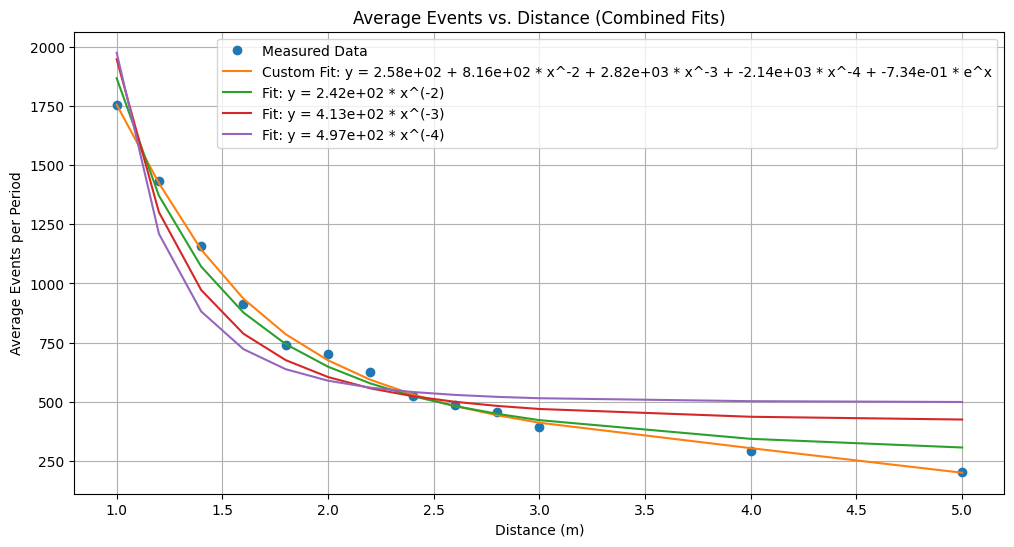

Custom Fit coefficients:
 c = 2.58e+02, b = 8.16e+02, d = 2.82e+03, f = -2.14e+03, e = -7.34e-01
Custom Fit R^2: 1.00
Fit: y = 2.42e+02 * x^(-2) R^2: 0.98
Fit: y = 4.13e+02 * x^(-3) R^2: 0.92
Fit: y = 4.97e+02 * x^(-4) R^2: 0.84


In [ ]:
def power_law(x, k, n):
	return k * x ** (-n)

distances_array = np.array(distances)
avg_events = avg_events_array[:, freq_idx]

valid_indices = ~np.isnan(avg_events)
distances_valid = distances_array[valid_indices]
avg_events_valid = avg_events[valid_indices]

X_custom = np.column_stack([
	np.ones_like(distances_valid),
	distances_valid**-2,
	distances_valid**-3,
	distances_valid**-4,
	np.exp(distances_valid),
])

y_custom = avg_events_valid


coefficients_custom, residuals_custom, rank_custom, s_custom = np.linalg.lstsq(X_custom, y_custom, rcond=None)
c_fit, b_fit, d_fit, f_fit, e_fit = coefficients_custom
y_fit_custom = X_custom @ coefficients_custom

ss_res_custom = np.sum((y_custom - y_fit_custom) ** 2)
ss_tot_custom = np.sum((y_custom - np.mean(y_custom)) ** 2)
r2_custom = 1 - (ss_res_custom / ss_tot_custom)

fits = []
labels = []
r2_scores = []

# Fit x**-2
X_2 = np.column_stack([np.ones_like(distances_valid), distances_valid**-2])
coefficients_2, residuals_2, rank_2, s_2 = np.linalg.lstsq(X_2, y_custom, rcond=None)
k_fit_2, n_fit_2 = coefficients_2
y_fit_2 = X_2 @ coefficients_2
fits.append(y_fit_2)
labels.append(f'Fit: y = {k_fit_2:.2e} * x^(-2)')

# R**2 for x**-2
ss_res_2 = np.sum((y_custom - y_fit_2) ** 2)
r2_2 = 1 - (ss_res_2 / ss_tot_custom)
r2_scores.append(r2_2)

# Fit x**-3
X_3 = np.column_stack([np.ones_like(distances_valid), distances_valid**-3])
coefficients_3, residuals_3, rank_3, s_3 = np.linalg.lstsq(X_3, y_custom, rcond=None)
k_fit_3, n_fit_3 = coefficients_3
y_fit_3 = X_3 @ coefficients_3
fits.append(y_fit_3)
labels.append(f'Fit: y = {k_fit_3:.2e} * x^(-3)')

# R**2 for x**-3
ss_res_3 = np.sum((y_custom - y_fit_3) ** 2)
r2_3 = 1 - (ss_res_3 / ss_tot_custom)
r2_scores.append(r2_3)

# Fit x**-4
X_4 = np.column_stack([np.ones_like(distances_valid), distances_valid**-4])
coefficients_4, residuals_4, rank_4, s_4 = np.linalg.lstsq(X_4, y_custom, rcond=None)
k_fit_4, n_fit_4 = coefficients_4
y_fit_4 = X_4 @ coefficients_4
fits.append(y_fit_4)
labels.append(f'Fit: y = {k_fit_4:.2e} * x^(-4)')

# R**2 for x**-4
ss_res_4 = np.sum((y_custom - y_fit_4) ** 2)
r2_4 = 1 - (ss_res_4 / ss_tot_custom)
r2_scores.append(r2_4)

plt.figure(figsize=(12, 6))
plt.plot(distances_valid, avg_events_valid, 'o', label='Measured Data')
plt.plot(distances_valid, y_fit_custom, '-', label=f'Custom Fit: y = {c_fit:.2e} + {b_fit:.2e} * x^-2 + {d_fit:.2e} * x^-3 + {f_fit:.2e} * x^-4 + {e_fit:.2e} * e^x')

for fit, label in zip(fits, labels):
	plt.plot(distances_valid, fit, '-', label=label)

plt.xlabel('Distance (m)')
plt.ylabel('Average Events per Period')
plt.title('Average Events vs. Distance (Combined Fits)')
plt.legend()
plt.grid(True)
plt.show()

print(f"Custom Fit coefficients:\n c = {c_fit:.2e}, b = {b_fit:.2e}, d = {d_fit:.2e}, f = {f_fit:.2e}, e = {e_fit:.2e}")
print(f"Custom Fit R^2: {r2_custom:.2f}")

for i, (label, r2) in enumerate(zip(labels, r2_scores)):
	print(f"{label} R^2: {r2:.2f}")

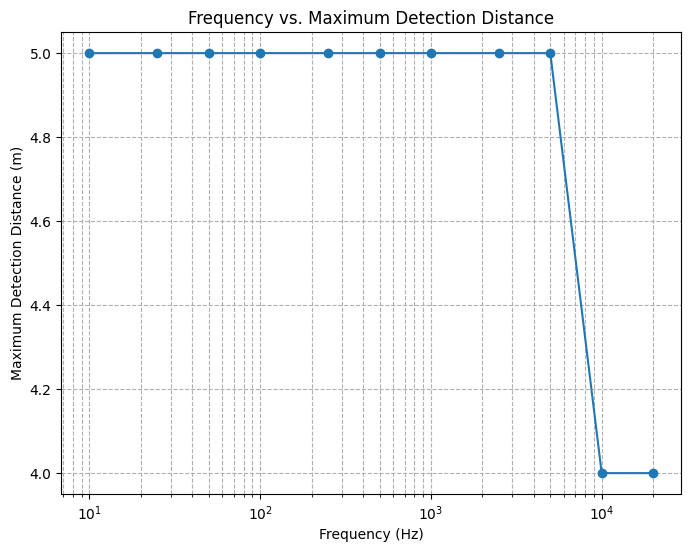

In [ ]:
max_distances = []

# this needs some reajdustment
detection_threshold = 10

for freq_idx, frequency in enumerate(frequencies):
	avg_events_per_distance = avg_events_array[:, freq_idx]
	valid_indices = np.where(avg_events_per_distance > detection_threshold)[0]

	if valid_indices.size > 0:
		max_distance = distances[valid_indices[-1]]
		max_distances.append(max_distance)
		
	else:
		max_distances.append(np.nan)

plt.figure()
plt.plot(frequencies, max_distances, 'o-')
plt.xscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Maximum Detection Distance (m)')
plt.title('Frequency vs. Maximum Detection Distance')
plt.grid(True, which="both", ls="--")
plt.show()